# Notebook de nettoyage et d'analyse de données RH, de cantine et de météo

## Introduction

## Chargement des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
import calendar
from sqlalchemy import create_engine

### Chargement des variables d'environnement

In [2]:
# Charger les variables d'environnement à partir du fichier .env
load_dotenv()

# Utiliser les variables d'environnement pour les paramètres de connexion
server = os.getenv("SERVER")
database = os.getenv("DATABASE")
user = os.getenv("AZUREUSER")
password = os.getenv("PASSWORD")

### Connexion à la base de données

In [3]:
# Créer la chaîne de connexion
azure_connection_string = f"mssql+pyodbc://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"

# Créer le moteur SQLAlchemy
engine = create_engine(azure_connection_string)

### Chargement des données de présence RH

In [4]:
df_presence = pd.read_sql_query("SELECT * FROM PresenceRH", engine)

In [5]:
df_presence

,id_agent_anonymise,date_demi_j,id_motif,lib_motif,type_presence,origine,date_traitement
0,6099071,2023-08-30 14:00:00,29,Lieu de travail Forfait Jour,P,fiches,2024-01-19
1,2259083,2023-08-30 14:00:00,1,Lieu de travail,P,fiches,2024-01-19
2,7121702,2023-08-30 14:00:00,10,Congés Payés,A,fiches,2024-01-19
3,6517863,2023-08-30 14:00:00,15,Congés Post-Maternité,A,fiches,2024-01-19
4,1123313,2023-08-30 14:00:00,1,Lieu de travail,P,fiches,2024-01-19
...,...,...,...,...,...,...,...
386995,4353345,2024-02-10 14:00:00,30,Repos Hebdomadaire,A,fiches,2024-01-19
386996,2384054,2024-02-10 14:00:00,30,Repos Hebdomadaire,A,fiches,2024-01-19
386997,5758513,2024-02-10 14:00:00,7,Congés maladie,A,fiches,2024-01-19
386998,7847215,2024-02-10 14:00:00,30,Repos Hebdomadaire,A,fiches,2024-01-19


### Chargement des données de couverts

In [6]:
df_couverts = pd.read_sql_query("SELECT * FROM RepasVendus", engine)

In [7]:
df_couverts

,id_jour,nb_couvert
0,2023-09-01,80
1,2023-09-02,0
2,2023-09-03,0
3,2023-09-04,147
4,2023-09-05,160
...,...,...
154,2024-02-02,151
155,2024-02-03,0
156,2024-02-04,0
157,2024-02-05,189


### Chargement des données météo

In [8]:
df_temperature = pd.read_sql_query("SELECT * FROM Meteo", engine)

In [9]:
df_temperature

,id_jour,temperature
0,2023-09-01,21.8
1,2023-09-02,28.8
2,2023-09-03,30.0
3,2023-09-04,30.0
4,2023-09-05,31.5
...,...,...
176,2024-02-24,6.9
177,2024-02-25,8.4
178,2024-02-26,9.8
179,2024-02-27,6.8


## Prétraitement des données

### Extraction du moment de la journée

In [10]:
# Extraire l'heure et déterminer le moment (matin ou après-midi)
df_presence['Moment'] = df_presence['date_demi_j'].dt.hour.apply(lambda x: 'Matin' if x == 8 else 'Après-midi')

# Supprimer les heures pour obtenir uniquement la date
df_presence['date_demi_j'] = df_presence['date_demi_j'].dt.date

### Nettoyage  et analyse des données de couverts

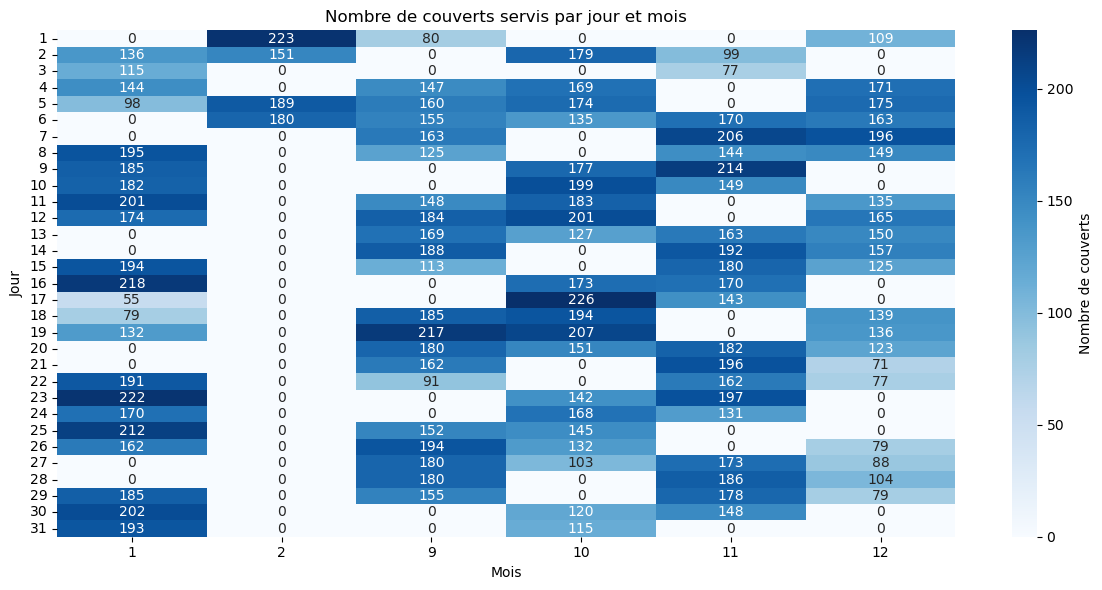

In [11]:
# Convertir la colonne 'DATE' en datetime
df_couverts['id_jour'] = pd.to_datetime(df_couverts['id_jour'], dayfirst=True)

# Supprimer les lignes avec des valeurs NaN dans la colonne 'NB_COUVERTS'
df_couverts = df_couverts.dropna(subset=['nb_couvert'])

# Créer une nouvelle colonne pour extraire le jour de la date
df_couverts['jour'] = df_couverts['id_jour'].dt.day

# Créer une nouvelle colonne pour extraire le mois de la date
df_couverts['mois'] = df_couverts['id_jour'].dt.month

# Créer une nouvelle colonne pour extraire l'année de la date
df_couverts['annee'] = df_couverts['id_jour'].dt.year

# Créer un pivot table pour avoir les couverts servis par jour et mois
pivot_table = df_couverts.pivot_table(index='jour', columns='mois', values='nb_couvert', aggfunc='sum')

# Remplacer les valeurs NaN par 0
pivot_table.fillna(0, inplace=True)

# Supprimer les trois colonnes créées après la génération du pivot_table
df_couverts.drop(['jour', 'mois', 'annee'], axis=1, inplace=True)

# Créer un heatmap avec seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt='.0f', cbar_kws={'label': 'Nombre de couverts'})
plt.title('Nombre de couverts servis par jour et mois')
plt.xlabel('Mois')
plt.ylabel('Jour')
plt.tight_layout()
plt.show()


## Analyse exploratoire des données

In [12]:
# Inspecter chaque colonne : 
for value in df_presence:
    print(df_presence[value].value_counts())
    print()


id_agent_anonymise
8005233    337
7411081    337
1649368    337
4402866    333
7391449    330
          ... 
80536       19
8041001     18
2096648     14
8231148     10
9345500      8
Name: count, Length: 1230, dtype: int64

date_demi_j
2023-12-20    2404
2023-12-19    2403
2023-12-21    2403
2023-12-18    2403
2023-12-14    2402
              ... 
2023-09-03    2220
2023-09-01    2220
2023-08-31    2212
2024-02-10    1933
2023-08-30     371
Name: count, Length: 165, dtype: int64

id_motif
30    106097
1     104138
29     73048
50     19125
10     17301
5      15885
7      15343
0       5314
4       5047
14      4818
31      3560
21      3265
6       2884
15      2853
3       1672
22      1547
11       861
26       620
16       587
18       433
12       396
17       394
2        359
48       320
51       244
45       187
20       170
19       142
33        61
32        52
59        51
24        42
23        38
9         35
52        30
49        28
46        16
13        15
44         

### Répartition des présences et des absences

In [13]:
# Motifs de présence correspondant à une présence sur site
motifs_sur_site = ['Lieu de travail Forfait Jour']

# Filtrer les données pour ne conserver que les motifs de présence sur site
presence_sur_site = df_presence[df_presence['lib_motif'].isin(motifs_sur_site)]

# Renommer le type de présence en 'PS' pour les motifs sur site
df_presence.loc[df_presence['lib_motif'].isin(motifs_sur_site), 'type_presence'] = 'PS'

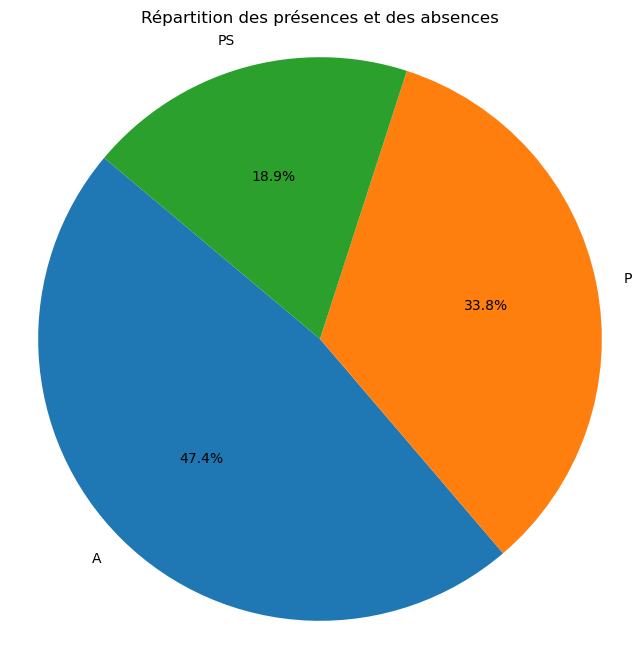

In [14]:
# Calcul de la répartitionAmazon Redshift, SQL Server, etc.
presence_counts = df_presence['type_presence'].value_counts()

# Création du diagramme à secteurs
plt.figure(figsize=(8, 8))
plt.pie(presence_counts, labels=presence_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des présences et des absences')
plt.axis('equal')
plt.show()

### Répartition des motifs d'absence

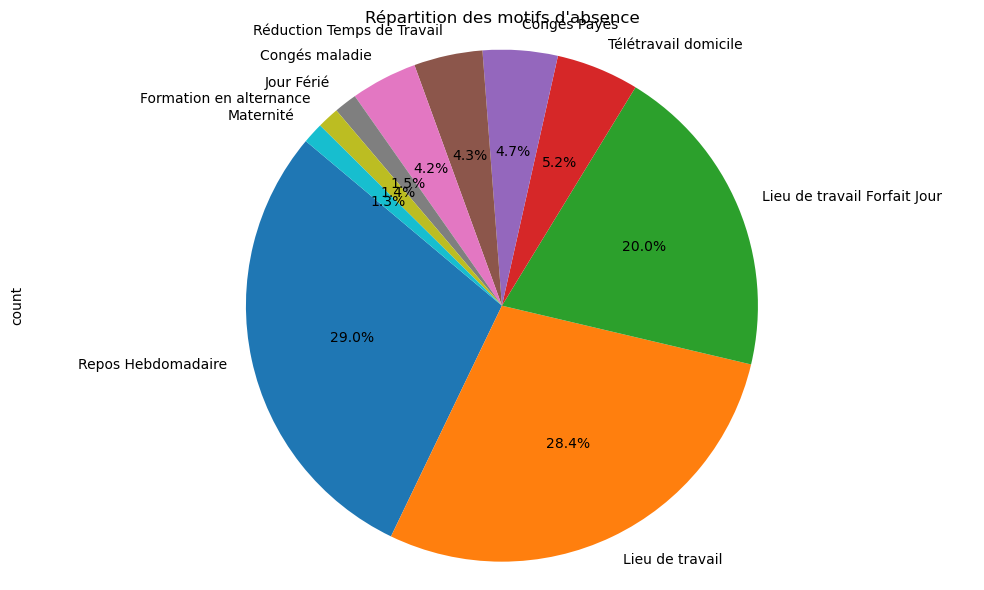

In [15]:
# Répartition des motifs d'absence
motifs_absence = df_presence['lib_motif'].value_counts().head(10)
plt.figure(figsize=(10, 6))
motifs_absence.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Répartition des motifs d\'absence')
plt.axis('equal')
plt.tight_layout()
plt.show()

### Analyse des présences sur site

In [16]:
# Vérifier les données de présence sur site
presence_data = df_presence[df_presence['type_presence'] == 'PS'].groupby('lib_motif').size()
print("Données de présence sur site:")
print(presence_data)

# Vérifier les données de présence
presence_data = df_presence[df_presence['type_presence'] == 'P'].groupby('lib_motif').size()
print("Données de présence :")
print(presence_data)

# Vérifier les données d'absence
absence_data = df_presence[df_presence['type_presence'] == 'A'].groupby('lib_motif').size()
print("Données d'absence :")
print(absence_data)

Données de présence sur site:
lib_motif
Lieu de travail Forfait Jour    73048
dtype: int64
Données de présence :
lib_motif
Déplacement                               359
Formation                                1672
Formation en alternance                  5047
Heures Supplémentaires Récupérables        35
Lieu de travail                        104138
Réunion CSE                                30
Réunion CSSCT                               3
Réunion commission CIE                      9
Travail délocalisé agence                 244
Télétravail domicile                    19125
dtype: int64
Données d'absence :
lib_motif
Absence Autre Non Payée                    52
Absence Autre Payée                        61
Absence CET                               620
Absence Longue Durée                     3560
Absence Mandat Elu Local                    4
Absence maladie / Pandémie                 51
Accident de trajet                         15
Accident du travail                       396
Articl

### Visualisation des données de présence par mois

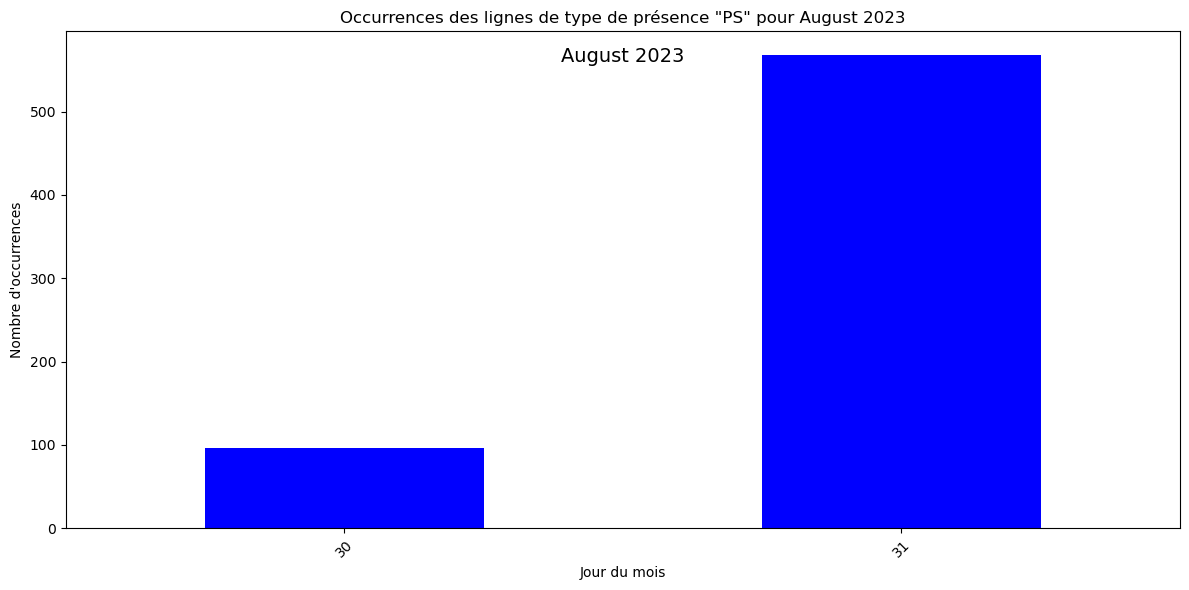

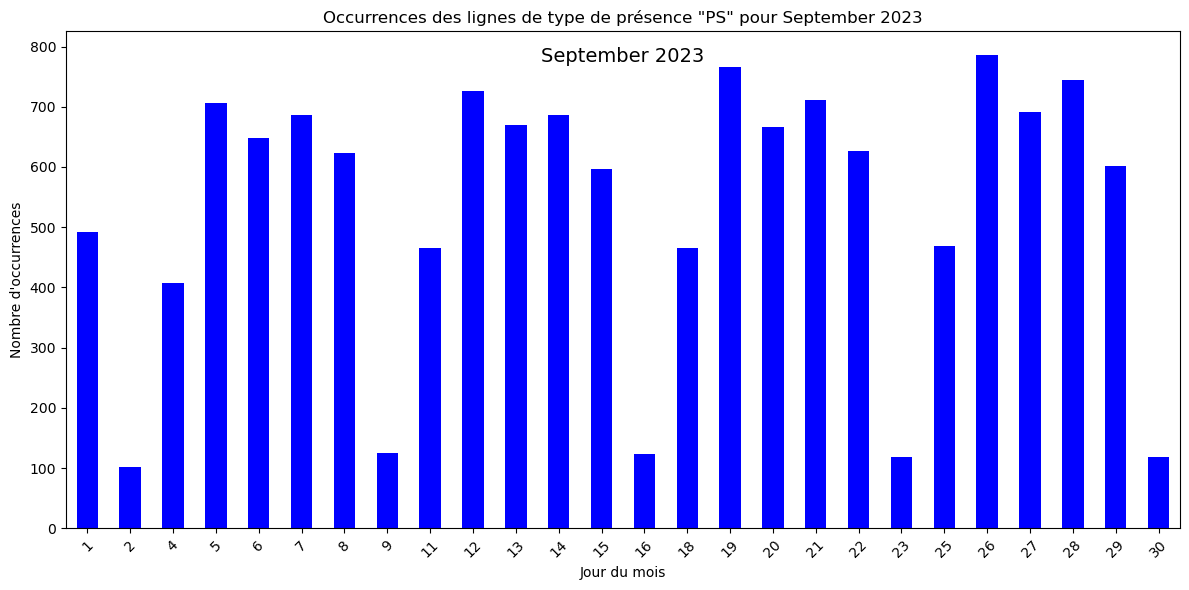

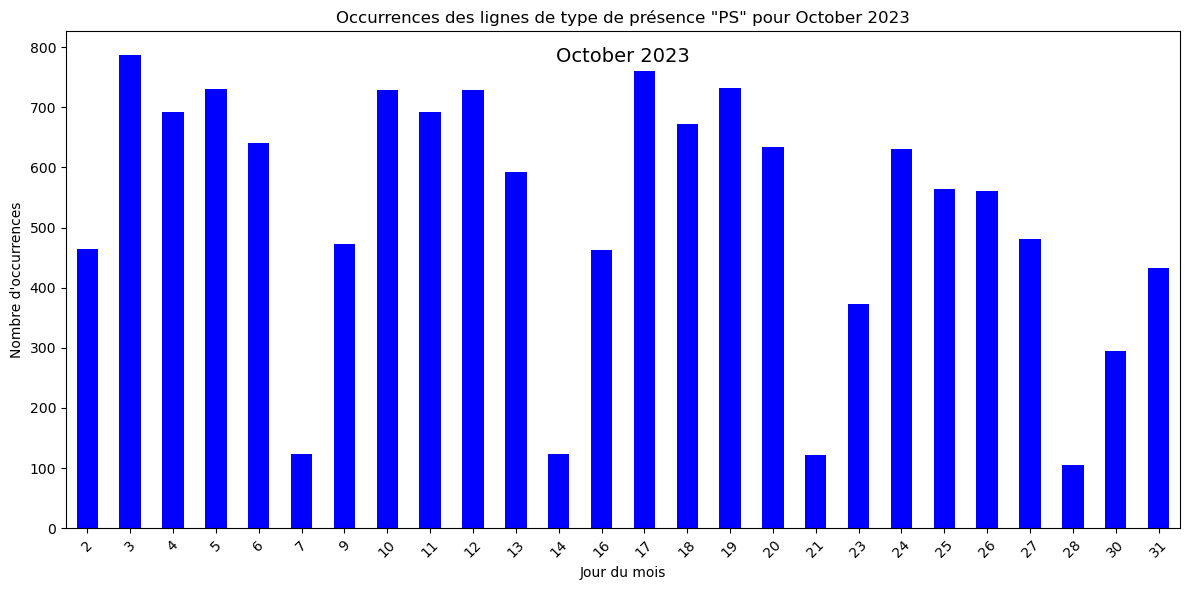

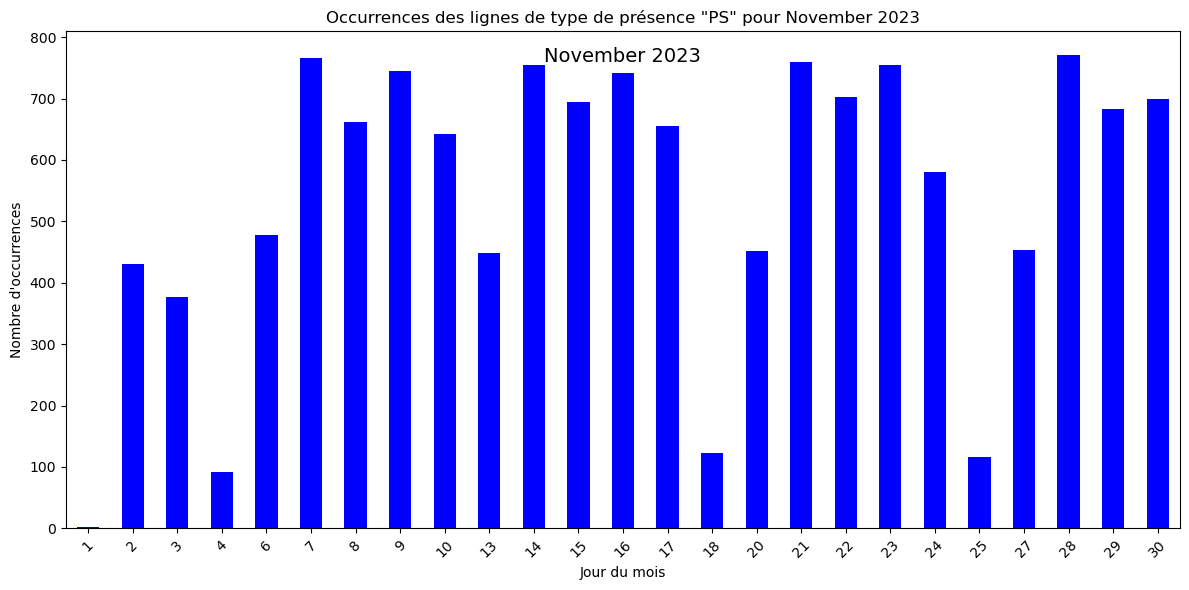

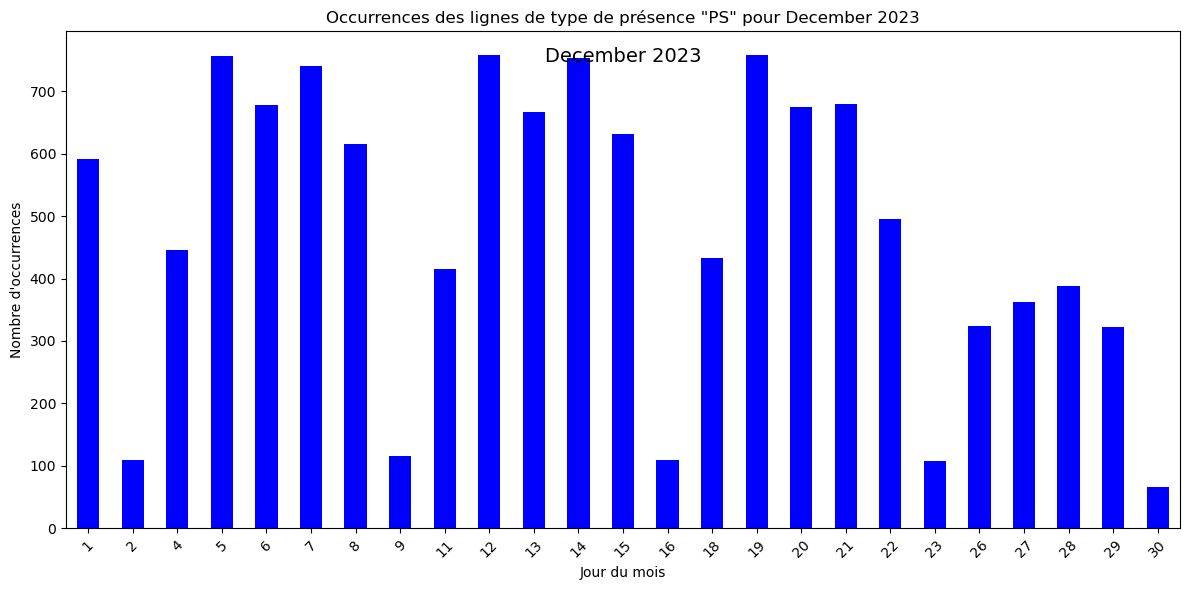

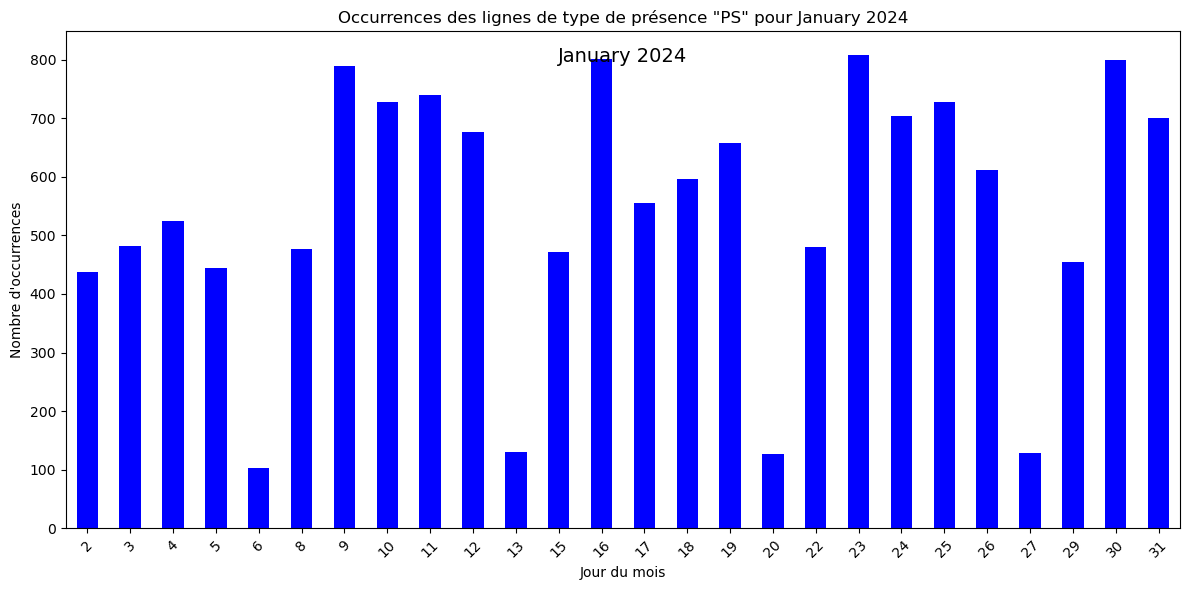

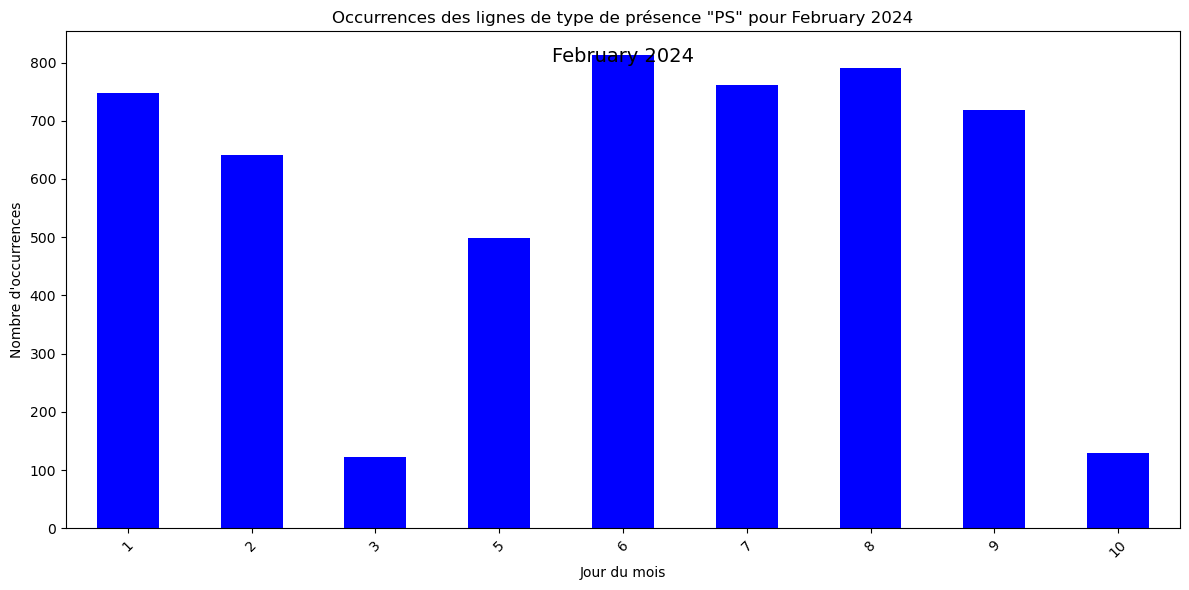

In [17]:
# Convertir la colonne 'DATE_DEMI_J' en datetime
df_presence['date_demi_j'] = pd.to_datetime(df_presence['date_demi_j'], dayfirst=True)

# Filtrer les données pour le type de présence "PS"
presence_data = df_presence[df_presence['type_presence'] == 'PS']

# Itérer sur chaque mois de janvier 2023 à février 2024
for year in range(2023, 2025):
    for month in range(1, 13):
        # Filtrer les données pour le mois en cours
        presence_data_month = presence_data[(presence_data['date_demi_j'].dt.year == year) & (presence_data['date_demi_j'].dt.month == month)]
        
        # Vérifier s'il y a des données pour ce mois
        if not presence_data_month.empty:
            # Compter les occurrences par jour
            presence_per_day_month = presence_data_month.groupby(presence_data_month['date_demi_j'].dt.day).size()

            # Créer le graphique
            plt.figure(figsize=(12, 6))
            presence_per_day_month.plot(kind='bar', color='blue')
            plt.xlabel('Jour du mois')
            plt.ylabel("Nombre d'occurrences")
            plt.title(f'Occurrences des lignes de type de présence "PS" pour {calendar.month_name[month]} {year}')
            plt.xticks(rotation=45)
            
            # Ajouter le texte pour indiquer le mois et l'année
            plt.text(0.5, 0.95, f"{calendar.month_name[month]} {year}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=14)
            
            plt.tight_layout()
            plt.show()



## Analyse de corrélation entre les données de présence, de météo et de cantine

### Analyse de la corrélation entre présence sur site et nombre de couverts servis

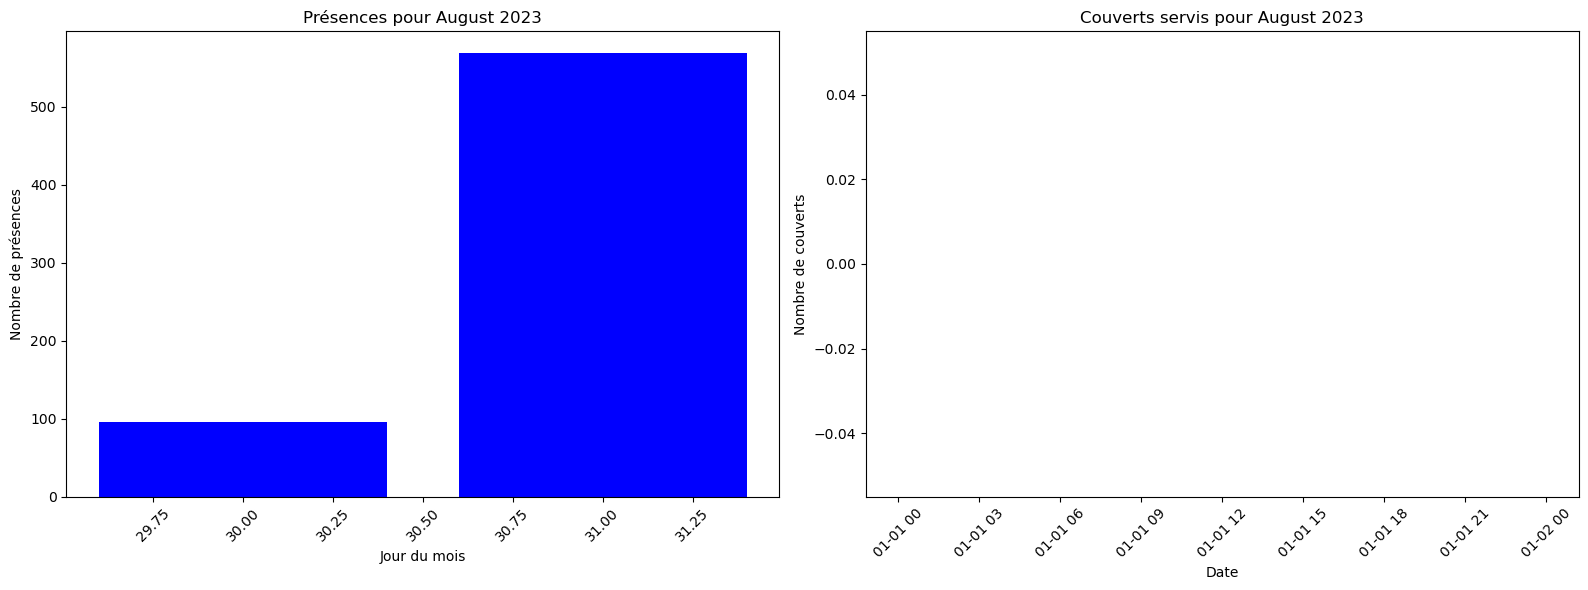

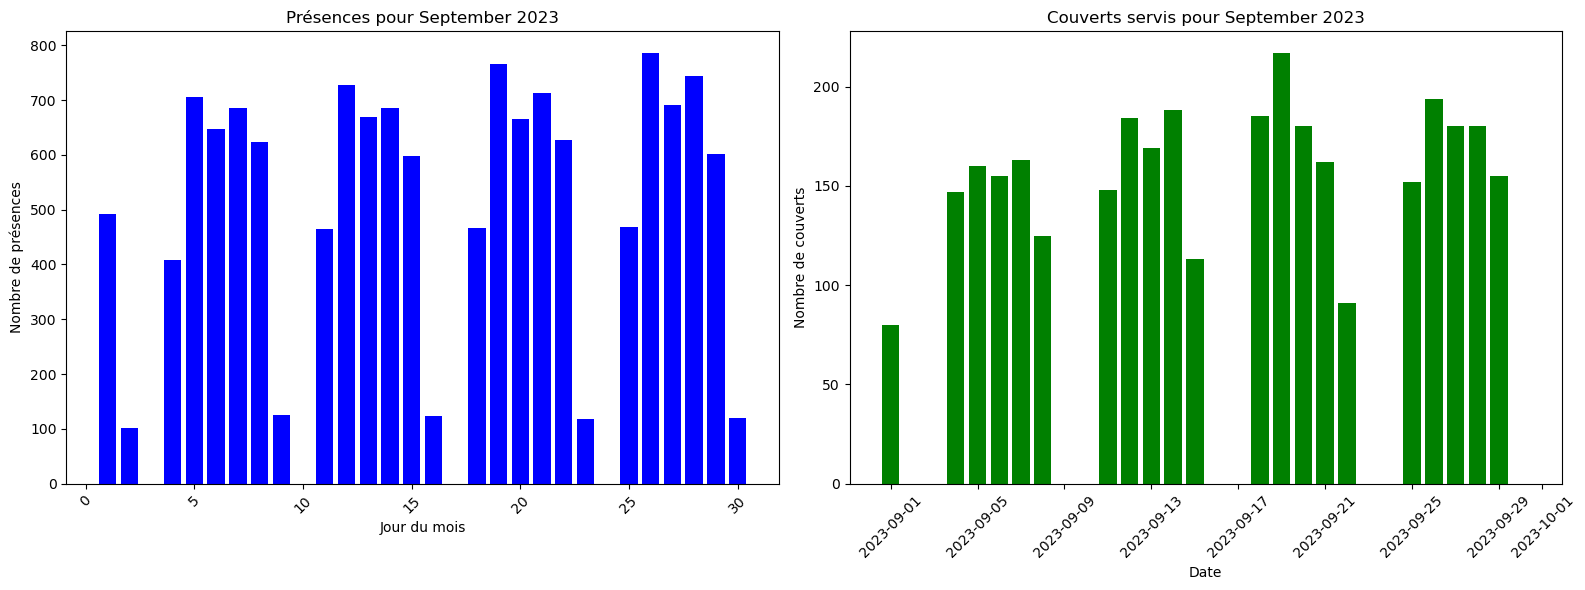

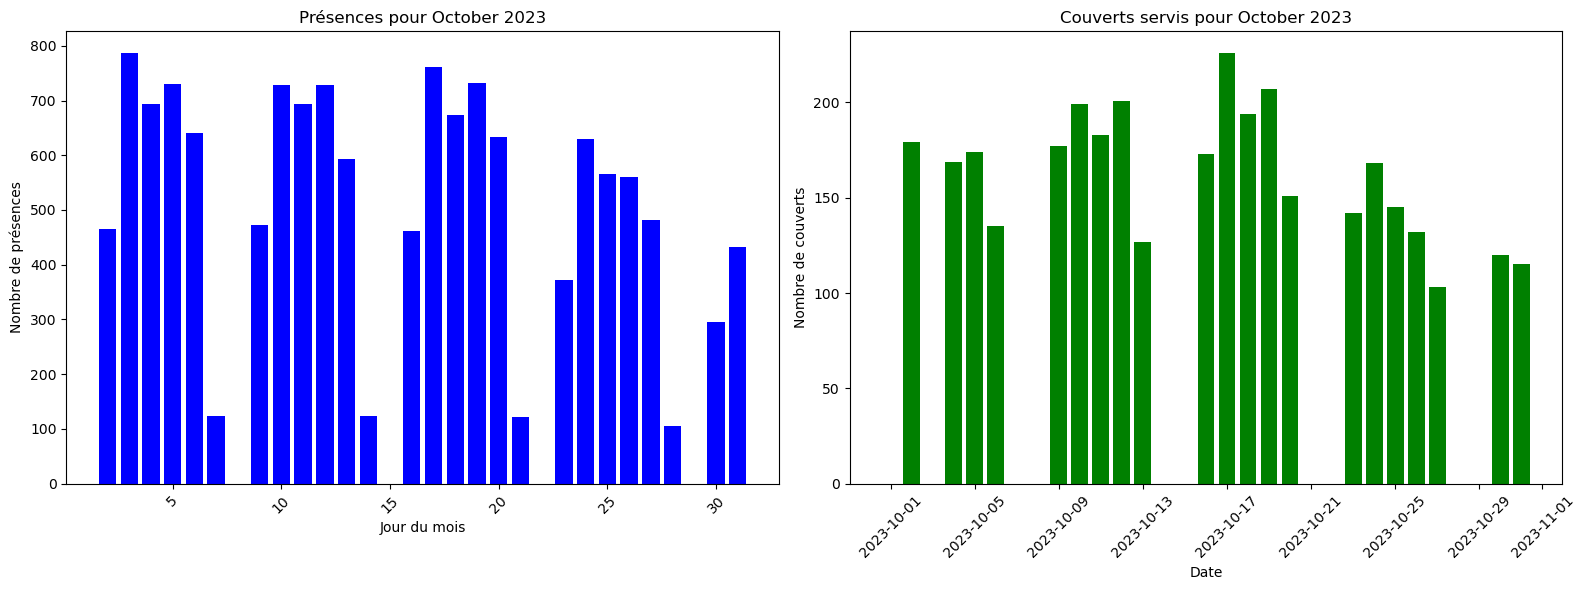

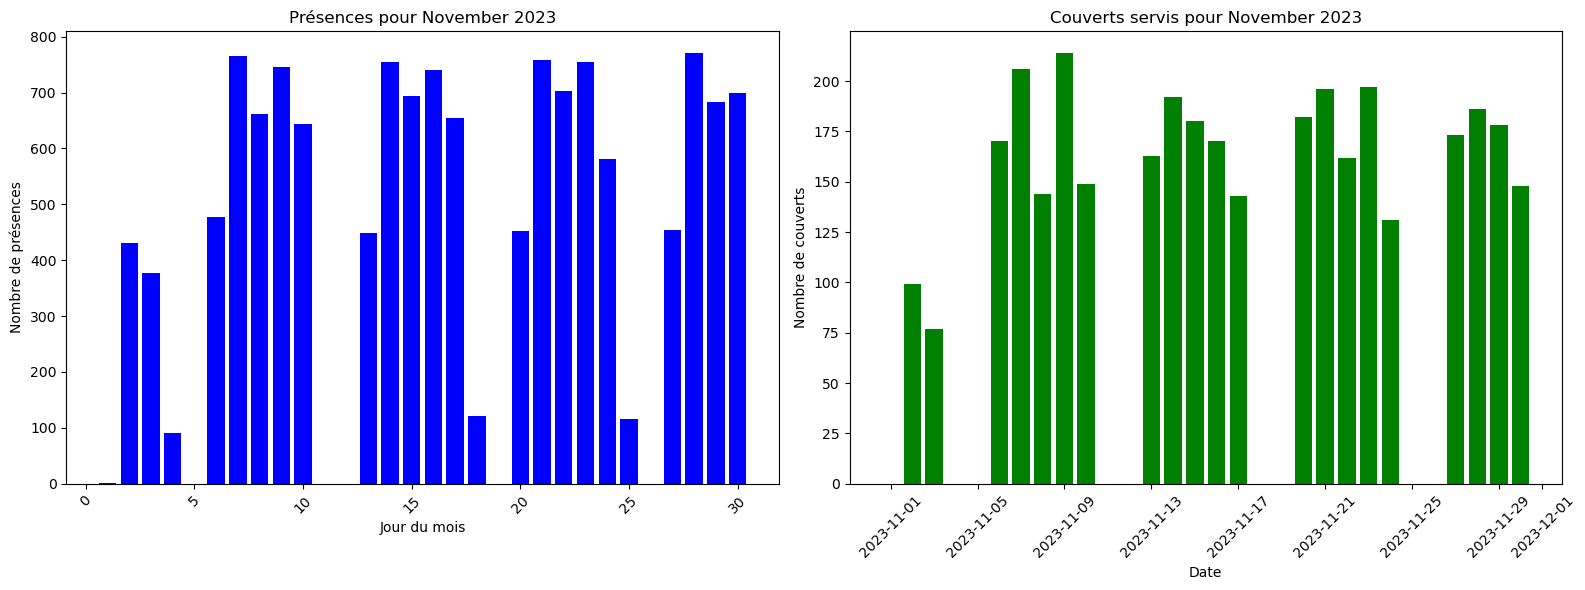

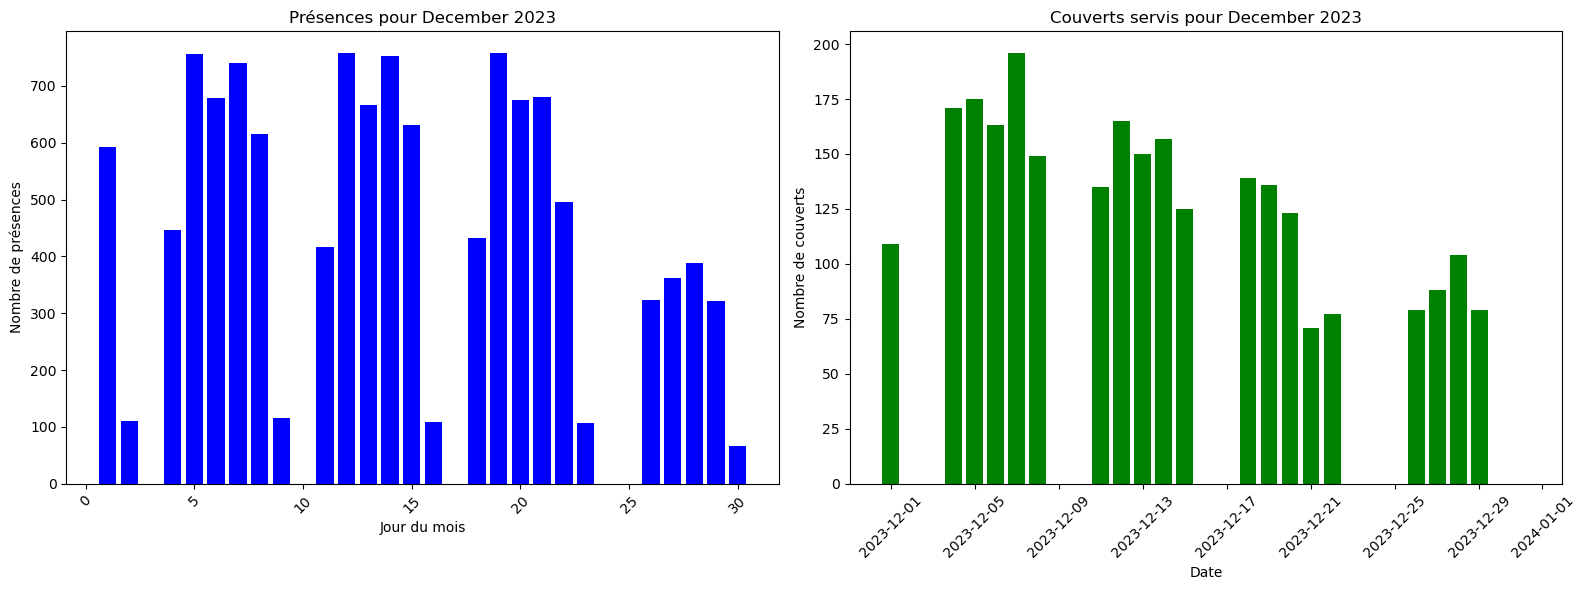

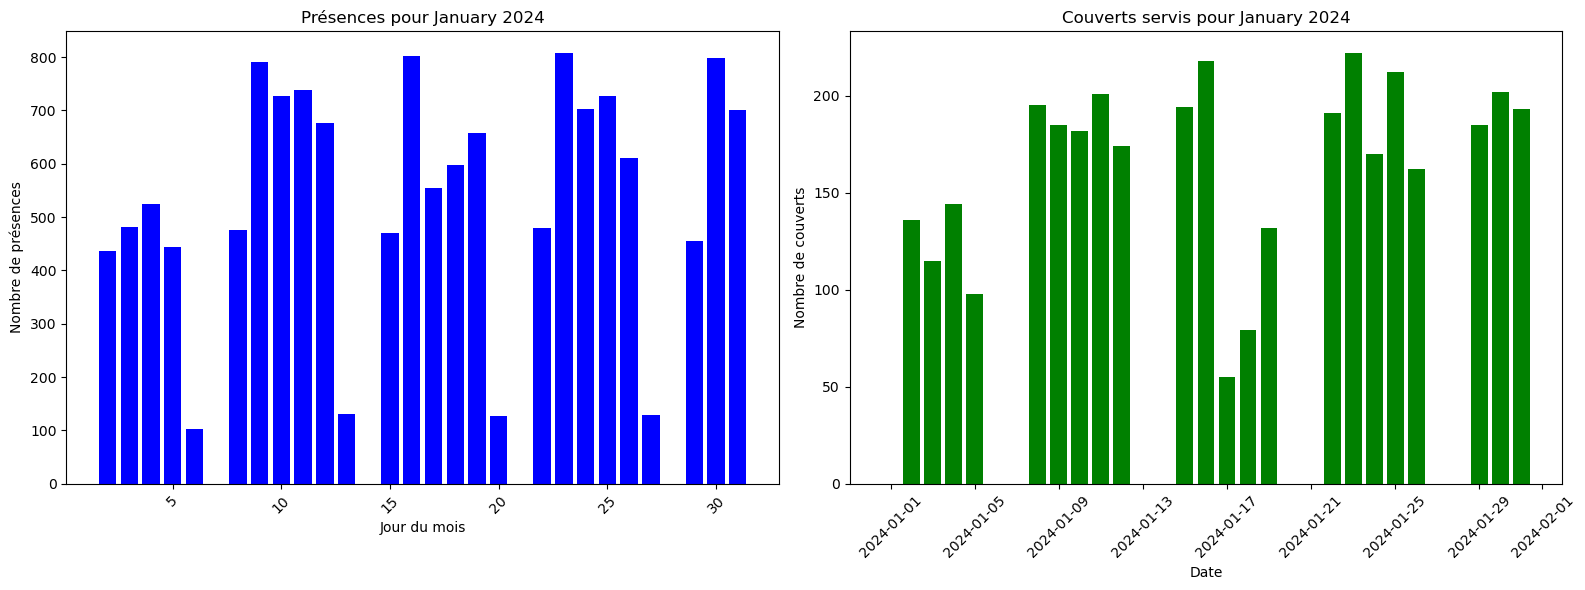

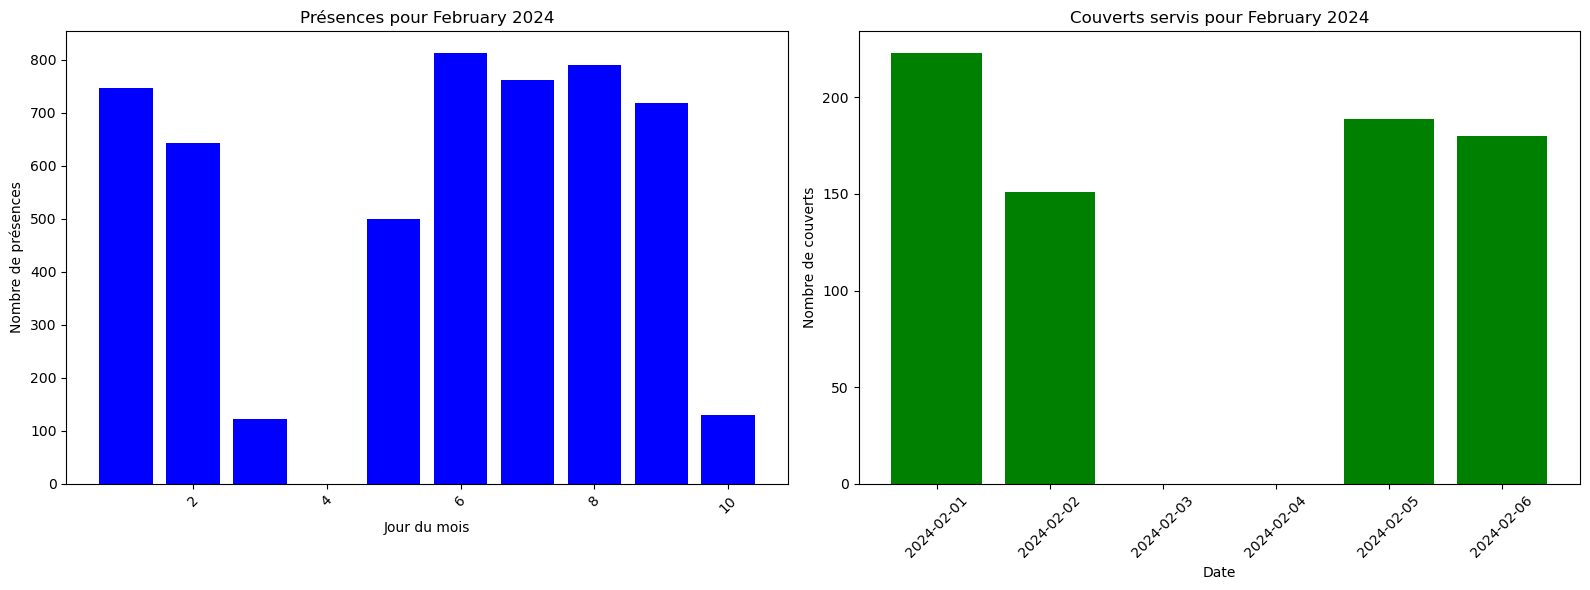

In [18]:
# Convertir la colonne 'DATE_DEMI_J' en datetime pour les deux DataFrames
df_presence['date_demi_j'] = pd.to_datetime(df_presence['date_demi_j'], dayfirst=True)
df_couverts['id_jour'] = pd.to_datetime(df_couverts['id_jour'], dayfirst=True)

# Filtrer les données pour le type de présence "PS"
presence_data = df_presence[df_presence['type_presence'] == 'PS']

# Itérer sur chaque mois de janvier 2023 à février 2024
for year in range(2023, 2025):
    for month in range(1, 13):
        # Filtrer les données de présence pour le mois en cours
        presence_data_month = presence_data[(presence_data['date_demi_j'].dt.year == year) & (presence_data['date_demi_j'].dt.month == month)]
        
        # Filtrer les données de couverts pour le mois en cours
        couverts_month = df_couverts[(df_couverts['id_jour'].dt.year == year) & (df_couverts['id_jour'].dt.month == month)]
        
        # Vérifier s'il y a des données de présence pour ce mois
        if not presence_data_month.empty:
            # Compter les occurrences de présence par jour
            presence_per_day_month = presence_data_month.groupby(presence_data_month['date_demi_j'].dt.day).size()
            
            # Créer une grille de sous-graphiques avec 1 ligne et 2 colonnes
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Tracer le graphique du nombre de présences par jour
            axes[0].bar(presence_per_day_month.index, presence_per_day_month.values, color='blue')
            axes[0].set_xlabel('Jour du mois')
            axes[0].set_ylabel("Nombre de présences")
            axes[0].set_title(f'Présences pour {calendar.month_name[month]} {year}')
            axes[0].tick_params(axis='x', rotation=45)
            
            # Tracer le graphique du nombre de couverts servis par jour
            axes[1].bar(couverts_month['id_jour'], couverts_month['nb_couvert'], color='green')
            axes[1].set_xlabel('Date')
            axes[1].set_ylabel('Nombre de couverts')
            axes[1].set_title(f'Couverts servis pour {calendar.month_name[month]} {year}')
            axes[1].tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            plt.show()


## Exportation des données nettoyées

### Création de la table CleanDataset

In [19]:
# Filtrer les données pour le type de présence "PS"
presence_data = df_presence[df_presence['type_presence'] == 'PS']

# Agréger les données de présence par date en comptant le nombre de présences sur site
presence_aggregated = presence_data.groupby(presence_data['date_demi_j'].dt.date).size().reset_index(name='nb_presence_sur_site')

# Convertir les colonnes en datetime
df_temperature['id_jour'] = pd.to_datetime(df_temperature['id_jour'])
presence_aggregated['date_demi_j'] = pd.to_datetime(presence_aggregated['date_demi_j'])

# Fusionner les données de présence agrégées avec les données météo en utilisant la colonne 'Date' de la cantine et 'id_jour' de la météo
df_merged = pd.merge(df_temperature, presence_aggregated, left_on='id_jour', right_on='date_demi_j', how='left')

# Supprimer la colonne 'id_jour' qui est redondante
df_merged.drop('date_demi_j', axis=1, inplace=True)

# Convertir la colonne 'id_jour' en datetime si elle n'est pas déjà au bon format
df_couverts['id_jour'] = pd.to_datetime(df_couverts['id_jour'])

# Fusionner les données fusionnées précédemment avec les données de couverts par jour en utilisant la colonne 'Date' de la cantine et 'id_jour' de la météo
df_final = pd.merge(df_merged, df_couverts, left_on='id_jour', right_on='id_jour', how='inner')

df_final = df_final.fillna(0)

In [20]:
df_final

,id_jour,temperature,nb_presence_sur_site,nb_couvert
0,2023-09-01,21.8,492.0,80
1,2023-09-02,28.8,101.0,0
2,2023-09-03,30.0,0.0,0
3,2023-09-04,30.0,408.0,147
4,2023-09-05,31.5,706.0,160
...,...,...,...,...
154,2024-02-02,7.7,642.0,151
155,2024-02-03,9.9,123.0,0
156,2024-02-04,9.7,0.0,0
157,2024-02-05,8.2,499.0,189


In [21]:
df_final.to_sql("CleanDataset", engine, index=False, if_exists="replace")

print("Table CleanDataset mise à jour")

Table CleanDataset mise à jour
